In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from skimage.draw import draw
from datetime import datetime
from scipy import interpolate
import scipy
import poppy

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# declare MagAO-X variables
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'surf_off': True,
           'n_tests': 10}

wavelen = np.round(fr_parm['wavelength'].to(u.nm).value).astype(int)
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2:3}nm'.format(fr_parm['npix'], br, wavelen)

# load the CSV prescription values
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
rx_loc = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_nowfe.csv'.format(parm_name)
rx_sys = mf.makeRxCSV(rx_loc, print_names=False)
n_folder = 10
n_filename = 11

# acquiring csv numerical values for specifically named optics
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Name'] == 'pupil':
        entrance_radius = test_opt['Radius_m']*u.m
    if test_opt['Type'] == 'mirror' or test_opt['Type'] == 'DM': # remove surfaces
        rx_sys[t_optic][n_folder] = 'none' # file folder
        rx_sys[t_optic][n_filename] = 'none' # file name
    if test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
        vapp_diam = test_opt['Radius_m']*2*u.m
    if test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number']

### Verifying the Pupil Patterns
4-f relays flip the pupil patterns around

Text(0.5, 1.0, 'M1 pupil (with bump)')

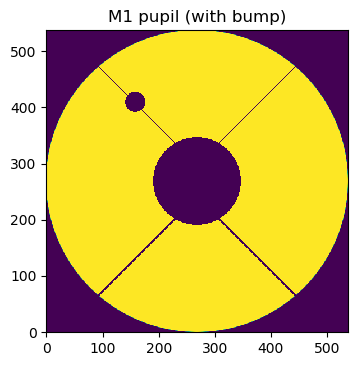

In [3]:
# check the pupil pattern first
m1_pupil = mf.mag_pupil_mask(samp=fr_parm['npix'], entrance_radius=3.25*u.m,
                             wavelength=632*u.nm, bump=True)
plt.figure(dpi=100)
plt.imshow(m1_pupil, origin='lower')
plt.title('M1 pupil (with bump)')

CPU times: user 38.9 s, sys: 8.44 s, total: 47.3 s
Wall time: 19 s


Text(0.5, 1.0, 'vAPP amplitude')

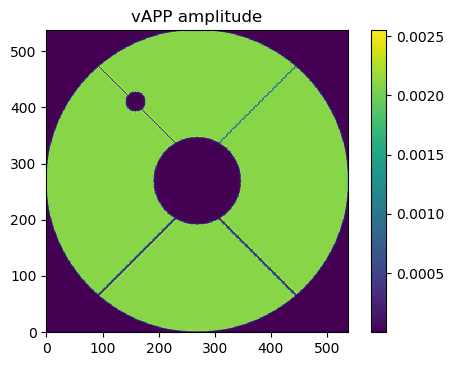

In [4]:
%%time
# vAPP plane analysis
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='vAPP-trans', bump=True)
vapp_psf, vapp_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

vapp_amp = poppy.utils.pad_or_crop_to_shape(vapp_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(vapp_amp, origin='lower')
plt.colorbar()
plt.title('vAPP amplitude')

### Building the bump mask

In [6]:
vapp_psf[0].header['pixelscl']*fr_parm['npix']

0.009025655633146633

In [7]:
vapp_psf[0].header['pixelscl']

1.677631158577441e-05

In [8]:
0.008604/vapp_psf[0].header['pixelscl']

512.8660108635454

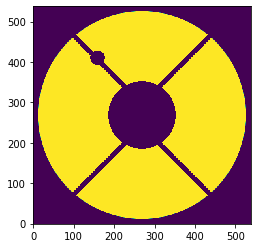

In [19]:
diam_pupil = vapp_psf[0].header['pixelscl']*fr_parm['npix']*u.m

# pupil mask based on coron_pupil_v3.pdf
diam_out = 0.008604*u.m
diam_in = 0.00279*u.m
w_spider = 1.917e-4#*u.m
y_spider = 4.707e-4#*u.m

# actuator bump mask coordinates based on mf.gen_mag_bump()
r_act_pix = 18 # scaled with vAPP pupil parameters
ac = 379 # pixel position
ar = 128 # pixel position

# Build the pieces
# outside diameter
vapp_ap = poppy.CircularAperture(name='outer', radius=diam_out/2)
# secondary obscuration with spider struts
vapp_sec = poppy.AsymmetricSecondaryObscuration(secondary_radius=diam_in/2,
                                                support_angle=[45, 135, -45, -135],
                                                support_width=[w_spider, w_spider, w_spider, w_spider],
                                                support_offset_x=[0, 0, 0, 0],
                                                support_offset_y=[y_spider, -1*y_spider, y_spider, -1*y_spider])
# actuator bump location
act = poppy.SecondaryObscuration(secondary_radius=vapp_psf[0].header['pixelscl']*r_act_pix, n_supports=0)
cen_loc = int(fr_parm['npix']/2)
act.shift_x = (cen_loc - ac)*vapp_psf[0].header['pixelscl']
act.shift_y = (cen_loc - ar)*vapp_psf[0].header['pixelscl']
# combine together
op_list = [vapp_ap, vapp_sec, act]
bump_map = poppy.CompoundAnalyticOptic(opticslist=op_list, name='bump_pupil')

# make wavefront to create transmission pupil pattern
wf = poppy.poppy_core.Wavefront(npix=fr_parm['npix'], diam=diam_pupil, 
                                wavelength=fr_parm['wavelength'])
bump_pupil = bump_map.get_transmission(wf)
plt.imshow(bump_pupil, origin='lower')

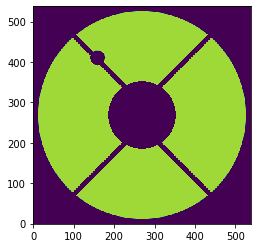

In [20]:
# verify with the amplitude map at the vAPP location
plt.imshow(bump_pupil*vapp_amp, origin='lower')

In [22]:
# write to file
mf.writeTRANSfile(trans_data=bump_pupil, 
                  pixelscl=vapp_psf[0].header['pixelscl'],
                  fileloc='bump_mask_vapp.fits')